# Sine Coulomb Matrix - Kernel Ridge Regression (Faber et al)

To predict Formation Energy of Solids using Sine Coulomb Matrix Featurization

In [1]:
## Mostly copied from https://github.com/hackingmaterials/matminer_examples/blob/master/scripts/kernel_ridge_SCM_OFM.py (By Kyle Bystrom)

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, train_test_split
import sklearn.metrics 
from sklearn.utils import shuffle

from matminer.featurizers.structure import SineCoulombMatrix, OrbitalFieldMatrix
from matminer.datasets.dataframe_loader import load_flla

import argparse
import time

Loading flla datasets

In [2]:
%%time
df = load_flla()
print ("SHAPE OF DATASET:" , df.shape)

SHAPE OF DATASET: (3938, 7)
CPU times: user 6.83 s, sys: 152 ms, total: 6.98 s
Wall time: 7.21 s


##### Data input

Here, we specify several different data sizes so that we can quantify performance of Kernel Ridge Regression algorithms with respect to the data input size. 

In [3]:
size = [10, 100, 500, 1000, df.shape[0]]

print ("DF SHAPE: ")
variable_df = []
for i in range(len(size)):
    variable_df.append(shuffle(df)[:size[i]])
    print (variable_df[i].shape)

df.head(1)

DF SHAPE: 
(10, 7)
(100, 7)
(500, 7)
(1000, 7)
(3938, 7)


,material_id,e_above_hull,formula,nsites,structure,formation_energy,formation_energy_per_atom
0,mp-10,0.107405,{'As': 1.0},2,"[[1.11758409 0.79025129 1.93571242] As, [3.352...",0.21481,0.107405


Sine Coulomb Matrix

In [4]:
scm = SineCoulombMatrix()

m = len(size)

for i in range(m):
    start = time.monotonic()
    variable_df[i] = scm.featurize_dataframe(variable_df[i], col_id='structure')
    # Take the eigenvalues of the SCMs to form vector descriptors
    variable_df[i]['sine coulomb matrix'] = pd.Series([np.sort(np.linalg.eigvals(s))[::-1] \
                                                              for s in variable_df[i]['sine coulomb matrix']], variable_df[i].index)
    finish = time.monotonic()
    print ("Time to featurize %i datasets: %f seconds" %(size[i], (finish-start)))

Time to featurize 10 datasets: 0.172675 seconds
Time to featurize 100 datasets: 0.254571 seconds
Time to featurize 500 datasets: 1.545911 seconds
Time to featurize 1000 datasets: 2.486995 seconds
Time to featurize 3938 datasets: 7.537202 seconds


Set up KernelRidgeRegression Model

In [5]:
class KrrScm(KernelRidge):
    """
    Custom SCM KernelRidge estimator

    This estimator ensures that scores are based on formation
    energy per atom by dividing predicted and actual y values
    by the number of nonzero items in each row of the X matrix.
    This is equivalent to dividing by the number of sites in
    the corresponding structure because each vector descriptor
    is a list of eigenvalues of the SCM.  The SCM is positive
    definite, so its eigenvalues are positive.  This class only
    changes the results slightly, however, so the script can
    be simplified by replacing the SCM estimator below with a
    plain KernelRidge() instance.
    """

    def __init__(self, alpha=1, kernel='linear', gamma=None,
                 degree=3, coef0=1, kernel_params=None):
        super(KrrScm, self).__init__(alpha, kernel, gamma,
                                     degree, coef0, kernel_params)

    def score(self, X, y):
        sizes = np.array([self.length(row) for row in X])
        y_pred = self.predict(X) / sizes
        y_true = y / sizes
        return sklearn.metrics.r2_score(y_true, y_pred)

    def length(self, vec):
        return vec[vec != 0].shape[0]

In [6]:
krr = KrrScm()
print (krr.get_params().keys())

dict_keys(['alpha', 'coef0', 'degree', 'gamma', 'kernel', 'kernel_params'])


Performing GridSearchCV for hyperparameter searching

In [7]:
NUM_SPLITS=5
inner_cv = KFold(n_splits=NUM_SPLITS-1, shuffle=False, random_state=0)
kf = KFold(NUM_SPLITS, False)

params = {}
params['scm'] = [{'kernel' : ['rbf'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma': [1/2.0/s/s for s in (20000,40000,80000,160000,320000)]},
    {'kernel' : ['laplacian'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma' : [1.0/s for s in (20000,40000,80000,160000,320000)]}]

model = GridSearchCV(krr, params['scm'], cv=inner_cv, refit=True)
model

GridSearchCV(cv=KFold(n_splits=4, random_state=0, shuffle=False),
       error_score='raise',
       estimator=KrrScm(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
    kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'alpha': [0.01, 0.001, 0.0001, 1e-05], 'gamma': [1.25e-09, 3.125e-10, 7.8125e-11, 1.953125e-11, 4.8828125e-12]}, {'kernel': ['laplacian'], 'alpha': [0.01, 0.001, 0.0001, 1e-05], 'gamma': [5e-05, 2.5e-05, 1.25e-05, 6.25e-06, 3.125e-06]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Input X and y

In [8]:
X = []
Y = []
N = []
nt = []

for i in range(m):
    X.append(variable_df[i]['sine coulomb matrix'].as_matrix())
    Y.append(variable_df[i]['formation_energy'].as_matrix())
    N.append(variable_df[i]['nsites'].as_matrix())
    nt.append(max(N[i]))

Append each vector descriptor with zeroes to make them all the same size.

In [9]:
# Append each vector descriptor with zeroes to make them all the same size.
for i in range(m):
    XLIST = []
    for j in range(len(X[i])):
        XLIST.append(np.append(X[i][j], np.zeros(nt[i] - X[i][j].shape[0])))
    X[i] = np.array(XLIST)
    print (X[i].shape)

(10, 22)
(100, 25)
(500, 25)
(1000, 25)
(3938, 25)


Evaluate accuracy of KRR model for varying data sizes using SCM featurization and time it

In [10]:
mae, rmse, r2 = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [11]:
import time
import warnings

time_used = np.zeros((m,))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(m):
        start = time.monotonic()
        for train_index, test_index in kf.split(X[i]):
            X_train, X_test = X[i][train_index], X[i][test_index]
            Y_train, Y_test = Y[i][train_index], Y[i][test_index]
            N_train, N_test = N[i][train_index], N[i][test_index]
            model.fit(X_train, Y_train)
            print("--- SCM PARAM OPT")
            print("---", model.best_params_)
            Y_pred = model.predict(X_test)
            mae[i] += np.mean(np.abs(Y_pred - Y_test)) / NUM_SPLITS
            rmse[i] += np.mean(((Y_pred - Y_test))**2)**0.5 / NUM_SPLITS
            r2[i] += sklearn.metrics.r2_score(Y_test, Y_pred) / NUM_SPLITS
        finish = time.monotonic()
        time_used[i] = finish - start
        print ("--Size of dataset: %i" %size[i])
        print ("SCM RESULTS MAE = %f, RMSE = %f, R-SQUARED = %f" % (mae[i], rmse[i], r2[i]))
        print ("TIME TO TEST SCM %f SECONDS" % (time_used[i]))
        print ()

--- SCM PARAM OPT
--- {'alpha': 1e-05, 'gamma': 1.953125e-11, 'kernel': 'rbf'}
--- SCM PARAM OPT
--- {'alpha': 0.01, 'gamma': 5e-05, 'kernel': 'laplacian'}
--- SCM PARAM OPT
--- {'alpha': 0.01, 'gamma': 5e-05, 'kernel': 'laplacian'}
--- SCM PARAM OPT
--- {'alpha': 0.0001, 'gamma': 3.125e-10, 'kernel': 'rbf'}
--- SCM PARAM OPT
--- {'alpha': 0.01, 'gamma': 5e-05, 'kernel': 'laplacian'}
--Size of dataset: 10
SCM RESULTS MAE = 37.476647, RMSE = 44.397664, R-SQUARED = -3878228.309556
TIME TO TEST SCM 1.408924 SECONDS

--- SCM PARAM OPT
--- {'alpha': 1e-05, 'gamma': 3.125e-06, 'kernel': 'laplacian'}
--- SCM PARAM OPT
--- {'alpha': 0.01, 'gamma': 6.25e-06, 'kernel': 'laplacian'}
--- SCM PARAM OPT
--- {'alpha': 0.01, 'gamma': 3.125e-06, 'kernel': 'laplacian'}
--- SCM PARAM OPT
--- {'alpha': 1e-05, 'gamma': 3.125e-06, 'kernel': 'laplacian'}
--- SCM PARAM OPT
--- {'alpha': 0.001, 'gamma': 3.125e-06, 'kernel': 'laplacian'}
--Size of dataset: 100
SCM RESULTS MAE = 9.126683, RMSE = 12.056420, R-SQU

#### Plot of time performance and accuracy of KRR model 

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (meV/atom)')
ax1.loglog(size, mae*1e3, color='r', marker='x', label='MAE')


ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_used, color='b', marker='.', label='time')

fig.legend(loc=(0.5, 0.8))

fig.tight_layout()
plt.show()

*Finding*: MAE is almost one order of magnitude larger than in the paper.

### Visualization of prediction

Add sine coulomb matrix featurizer

In [13]:
%%time
scm = SineCoulombMatrix()
df = scm.featurize_dataframe(df, col_id='structure')

CPU times: user 1.02 s, sys: 172 ms, total: 1.19 s
Wall time: 5.69 s


Form vector descriptors using eigenvalues of the SCMs

In [14]:
import os
df['sine coulomb matrix'] = pd.Series([np.sort(np.linalg.eigvals(s))[::-1] \
    for s in df['sine coulomb matrix']], df.index)

Input x and y

In [15]:
x = df['sine coulomb matrix'].as_matrix()
y = df['formation_energy_per_atom'].as_matrix()

Append each vector descriptor with zeros to make them all the same size

In [16]:
nt = max(df['nsites'])
XLIST = []
for i in range(len(x)):
    XLIST.append(np.append(x[i], np.zeros(nt - x[i].shape[0])))
x = np.array(XLIST)

Partition into training and testing set (80% training and 20% testing)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

Kernel Ridge Regression model (Using GridSearchCV to find best hyperparameter)

In [18]:
krr = KrrScm()
params = {}
params['scm'] = [{'kernel' : ['rbf'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma': [1/2.0/s/s for s in (20000,40000,80000,160000,320000)]},
    {'kernel' : ['laplacian'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma' : [1.0/s for s in (20000,40000,80000,160000,320000)]}]

In [19]:
hpsel = GridSearchCV(krr, params['scm'], cv=inner_cv, refit=True)

Train KRR model using training set data

In [20]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hpsel.fit(x_train, y_train)

Assign best hyperparameters to model

In [21]:
model = hpsel.best_estimator_

Prediction of data

In [22]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_train = cross_val_predict(model, x_train, y_train, cv=KFold(n_splits=5))
    cv_test = cross_val_predict(model, x_test, y_test, cv=KFold(n_splits=5))

In [23]:
mae_train, mae_test = sklearn.metrics.mean_absolute_error(y_train, cv_train), sklearn.metrics.mean_absolute_error(y_test, cv_test)
rmse_train, rmse_test = np.sqrt(sklearn.metrics.mean_squared_error(y_train, cv_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_test, cv_test))
r2_train, r2_test = sklearn.metrics.r2_score(y_train, cv_train), sklearn.metrics.r2_score(y_test, cv_test)

Plot predictions

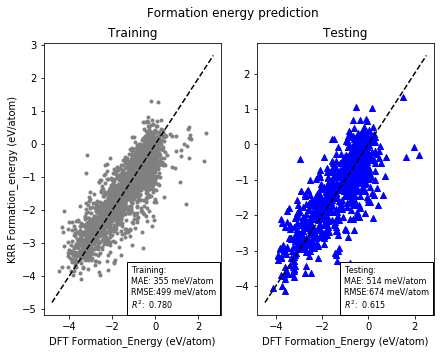

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Formation energy prediction")

ax1.scatter(y_train, cv_train, c='grey', marker='.')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.49, 0.026, 'Training:\nMAE: {:.0f} meV/atom\nRMSE:{:.0f} meV/atom\n$R^2$:  {:.3f}'.format(mae_train*1e3, rmse_train*1e3, r2_train),
         transform=ax1.transAxes, fontsize=8,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.set_title('Training')
ax1.set_xlabel('DFT Formation_Energy (eV/atom)')
ax1.set_ylabel('KRR Formation_energy (eV/atom)')

ax2.scatter(y_test, cv_test, c='b', marker='^')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')
ax2.text(1.69, 0.026, 'Testing:\nMAE: {:.0f} meV/atom\nRMSE:{:.0f} meV/atom\n$R^2$:  {:.3f}'.format(mae_test*1e3, rmse_test*1e3, r2_test),
         transform=ax1.transAxes, fontsize=8,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.set_title('Testing')
ax2.set_xlabel('DFT Formation_Energy (eV/atom)')

fig.set_size_inches(7, 5)

Interestingly, the MAE here is almost similar to the MAE shown in Jong's paper (0.37 eV/atom)